In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sodapy import Socrata

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
creds_file = open('./creds.json', 'r')
socrata_creds = json.loads(creds_file.read())

In [5]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", socrata_creds['app_token'])

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Data
---

### DHS Daily Report
Source: https://data.cityofnewyork.us/Social-Services/DHS-Daily-Report/k46n-sa2m

This dataset includes the daily number of families and individuals residing in the Department of Homeless Services (DHS) shelter system and the daily number of families applying to the DHS shelter system.

In [94]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k46n-sa2m", limit = 10_000);

# Convert to pandas DataFrame
daily_df = pd.DataFrame.from_records(results);

In [95]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 13 columns):
date_of_census                                             2216 non-null object
total_adults_in_shelter                                    2216 non-null object
total_children_in_shelter                                  2216 non-null object
total_individuals_in_shelter                               2216 non-null object
single_adult_men_in_shelter                                2216 non-null object
single_adult_women_in_shelter                              2216 non-null object
total_single_adults_in_shelter                             2216 non-null object
families_with_children_in_shelter                          2216 non-null object
adults_in_families_with_children_in_shelter                2216 non-null object
children_in_families_with_children_in_shelter              2216 non-null object
total_individuals_in_families_with_children_in_shelter_    2216 non-null object
adult_familie

# Functions

In [8]:
def adf(series_to_try):
    """
    a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
    """
    dftest = adfuller(series_to_try)
    result = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return result

In [9]:
def acf_pacf(series_to_plot, n_lag):
    """
    Plot ACF & PACF
    """
    plot_acf(series_to_plot, lags = n_lag);
    plt.ylabel('autocorrelation')
    plt.xlabel('lags');

    plot_pacf(series_to_plot, lags = n_lag);
    plt.ylabel('partial autocorrelation')
    plt.xlabel('lags');

In [10]:
def evaluate(data_to_evaluate, residual):
    
    """
    make residual graphs and print out MSE 
    """

    plt.figure(figsize = (12,5))
    plt.scatter(data_to_evaluate.index, residual)
    plt.title('Residuals')
    plt.axhline(0, color='red')

    return {"mean square error": sum(np.square(residual)) / len(residual)}

# Data Cleaning

The type of all columns is 'object'. `date_of_census` is datetime column and rest of the columns are numerical column. Change the types appropriately.

In [11]:
daily_df['date_of_census'] = daily_df['date_of_census'].apply(lambda x: x.split('T')[0])

In [12]:
daily_df.index = pd.to_datetime(daily_df['date_of_census'], format = "%Y/%m/%d")
daily_df = daily_df.drop('date_of_census', axis = 1)

In [13]:
daily_df = daily_df.apply(pd.to_numeric)

In [14]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2019-11-16 to 2013-08-21
Data columns (total 12 columns):
total_adults_in_shelter                                    2216 non-null int64
total_children_in_shelter                                  2216 non-null int64
total_individuals_in_shelter                               2216 non-null int64
single_adult_men_in_shelter                                2216 non-null int64
single_adult_women_in_shelter                              2216 non-null int64
total_single_adults_in_shelter                             2216 non-null int64
families_with_children_in_shelter                          2216 non-null int64
adults_in_families_with_children_in_shelter                2216 non-null int64
children_in_families_with_children_in_shelter              2216 non-null int64
total_individuals_in_families_with_children_in_shelter_    2216 non-null int64
adult_families_in_shelter                                  2216 non-null int64
indivi

When resampled by day ('D'), some rows are created. This indicates that missing days exist and these were filled in with null values.

In [15]:
daily_df.shape

(2216, 12)

In [16]:
daily_df.resample('D').mean().shape

(2279, 12)

Resampled by week('W') to avoid having any missing days.

In [17]:
daily_df.resample('W').mean().shape

(326, 12)

In [18]:
daily_df.resample('W').mean().isnull().sum()

total_adults_in_shelter                                    0
total_children_in_shelter                                  0
total_individuals_in_shelter                               0
single_adult_men_in_shelter                                0
single_adult_women_in_shelter                              0
total_single_adults_in_shelter                             0
families_with_children_in_shelter                          0
adults_in_families_with_children_in_shelter                0
children_in_families_with_children_in_shelter              0
total_individuals_in_families_with_children_in_shelter_    0
adult_families_in_shelter                                  0
individuals_in_adult_families_in_shelter                   0
dtype: int64

In [19]:
weekly_df = daily_df.resample('W').mean()

In [107]:
weekly_df.index

DatetimeIndex(['2013-08-25', '2013-09-01', '2013-09-08', '2013-09-15',
               '2013-09-22', '2013-09-29', '2013-10-06', '2013-10-13',
               '2013-10-20', '2013-10-27',
               ...
               '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-06',
               '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03',
               '2019-11-10', '2019-11-17'],
              dtype='datetime64[ns]', name='date_of_census', length=326, freq='W-SUN')

# EDA

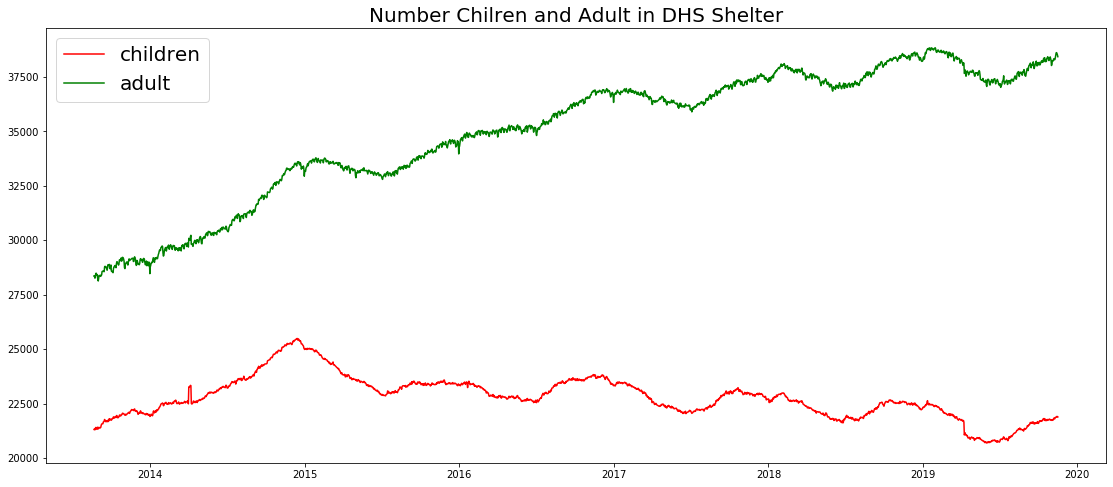

In [20]:
plt.figure(figsize = (19, 8))
plt.plot(daily_df['total_children_in_shelter'],color = 'red', label = 'children')
plt.plot(daily_df['total_adults_in_shelter'],color = 'green', label = 'adult')
plt.title('Number Chilren and Adult in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

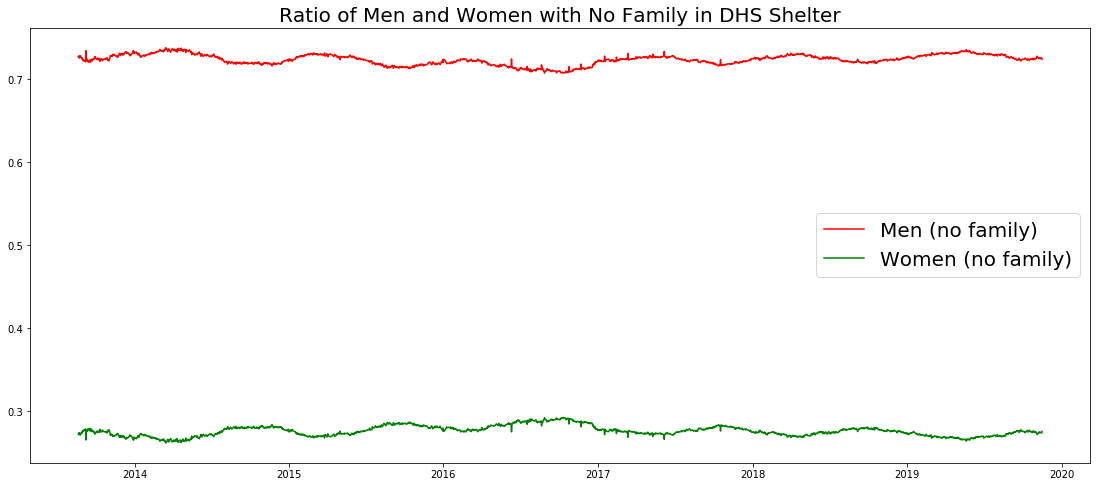

In [21]:
plt.figure(figsize = (19, 8))

plt.plot(daily_df['single_adult_men_in_shelter'] / daily_df['total_single_adults_in_shelter'],
         color = 'red', label = 'Men (no family)')
plt.plot(daily_df['single_adult_women_in_shelter']/ daily_df['total_single_adults_in_shelter']
         ,color = 'green', label = 'Women (no family)')
plt.title('Ratio of Men and Women with No Family in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

look into war veteran data (more men)

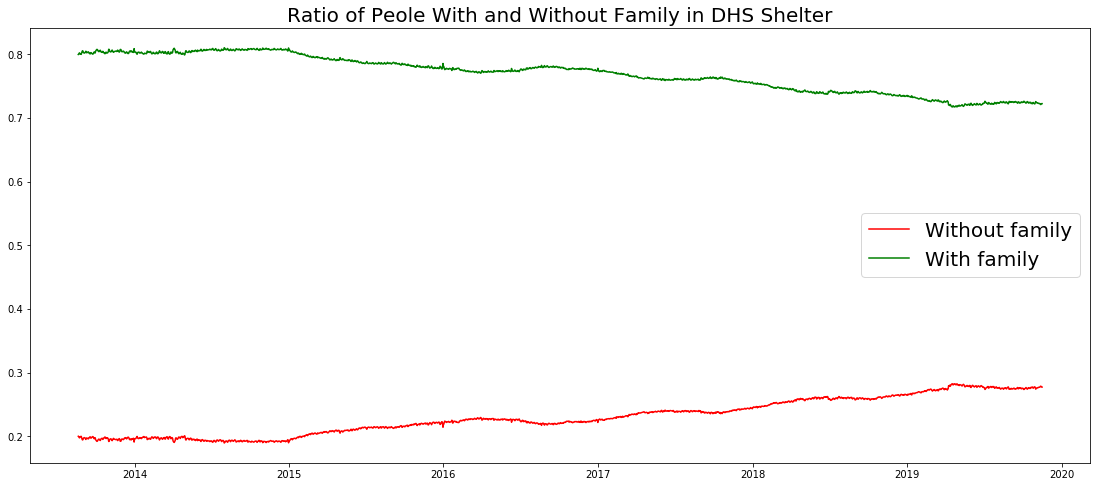

In [22]:
plt.figure(figsize = (19, 8))
plt.plot(daily_df['total_single_adults_in_shelter'] / daily_df['total_individuals_in_shelter'],
         color = 'red', label = 'Without family')
plt.plot((daily_df['total_individuals_in_families_with_children_in_shelter_']\
          + daily_df['individuals_in_adult_families_in_shelter'])/ daily_df['total_individuals_in_shelter']
         ,color = 'green', label = 'With family')
plt.title('Ratio of Peole With and Without Family in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

- Check DHS policy about family
- Is this related to men having higher criminal record?

# Target EDA ( weekly_df )

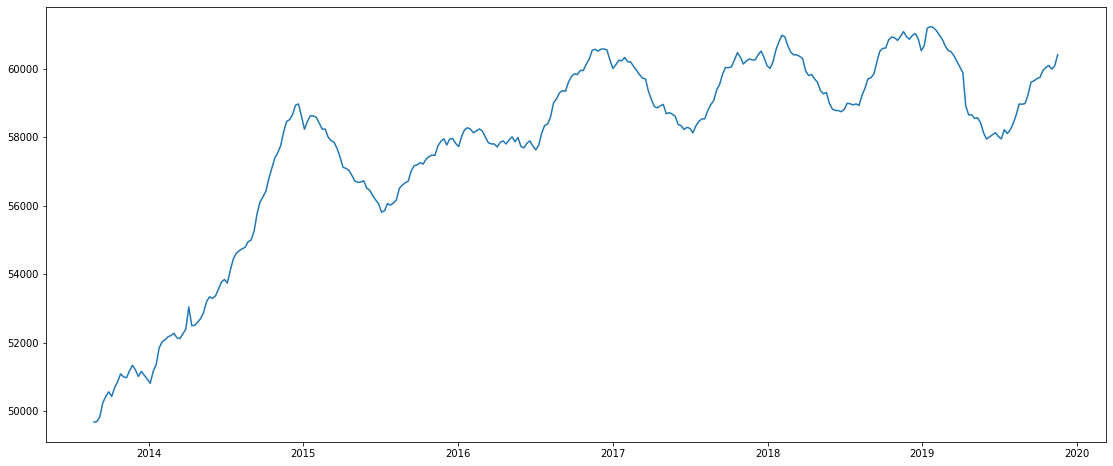

In [23]:
plt.figure(figsize = (19, 8))
plt.plot(weekly_df['total_individuals_in_shelter'], label = 'total') 

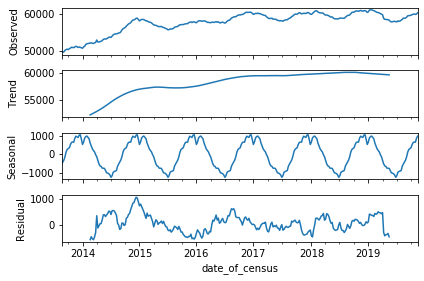

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'])
decomp.plot();

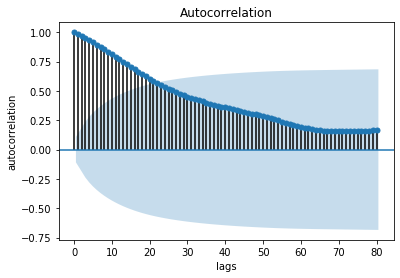

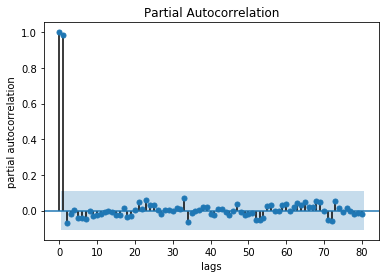

In [25]:
acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

The small lags values have large and positive correlations. This is a evidence of a trend.

The evidence of seasonailty observed in seasonal_decompose plot is not very evident in PACF plot.

# Try OLS regression

In [26]:
weekly_lag = weekly_df.copy()

In [27]:
# Create a column called `lag_1` that lags Passengers by one month.
weekly_df['lag_1'] = weekly_df['total_individuals_in_shelter'].shift(1)

# Create a column called `lag_2` that lags Passengers by two months.
weekly_df['lag_2'] = weekly_df['total_individuals_in_shelter'].shift(2)

weekly_df['lag_3'] = weekly_df['total_individuals_in_shelter'].shift(3)

In [28]:
weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2', 'lag_3']].corr()

,total_individuals_in_shelter,lag_1,lag_2,lag_3
total_individuals_in_shelter,1.000000,0.997913,0.994159,0.989754
lag_1,0.997913,1.000000,0.997928,0.994180
lag_2,0.994159,0.997928,1.000000,0.997926
lag_3,0.989754,0.994180,0.997926,1.000000


### OLS model 1
- Includes lag1,2 and 3

In [29]:
X = weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2', 'lag_3']]\
    .drop('total_individuals_in_shelter', axis = 1)
y = weekly_df['total_individuals_in_shelter']

In [30]:
# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)

In [31]:
# Before fitting a model in statsmodels, what do we need
# to do? (Hint: Think intercept.)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Confirm.
X_train.head()

/Users/dae/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,lag_1,lag_2,lag_3
date_of_census,,,,
2013-08-25,1.0,NaN,NaN,NaN
2013-09-01,1.0,49677.200000,NaN,NaN
2013-09-08,1.0,49689.000000,49677.2,NaN
2013-09-15,1.0,49829.600000,49689.0,49677.2
2013-09-22,1.0,50238.714286,49829.6,49689.0


In [32]:
# statsmodels won't be able to handle missing values.

X_train.dropna(inplace = True)

y_train = y_train[X_train.index]

In [33]:
X_train.head()

,const,lag_1,lag_2,lag_3
date_of_census,,,,
2013-09-15,1.0,49829.600000,49689.000000,49677.200000
2013-09-22,1.0,50238.714286,49829.600000,49689.000000
2013-09-29,1.0,50423.285714,50238.714286,49829.600000
2013-10-06,1.0,50560.571429,50423.285714,50238.714286
2013-10-13,1.0,50426.000000,50560.571429,50423.285714


In [34]:
# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

lm = sm.OLS(y_train, X_train)

In [35]:
# Then we fit our model.
lm_results = lm.fit()

In [36]:
# Display our summary!
print(lm_results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     total_individuals_in_shelter   R-squared:                       0.997
Model:                                      OLS   Adj. R-squared:                  0.997
Method:                           Least Squares   F-statistic:                 2.595e+04
Date:                          Tue, 19 Nov 2019   Prob (F-statistic):          1.48e-314
Time:                                  11:22:20   Log-Likelihood:                -1669.5
No. Observations:                           257   AIC:                             3347.
Df Residuals:                               253   BIC:                             3361.
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

**Observations**
- P-value for 'lag_3' is 0.995. This indicates that 'lag_3' is not statistically significant. This is indicated in the PACF plot above as well.

In [37]:
# Generate predicted test values.
lm_results.predict(X_test)

date_of_census
2018-08-19    59333.902352
2018-08-26    59503.541720
2018-09-02    59801.103053
2018-09-09    59747.969309
2018-09-16    59881.093540
                  ...     
2019-10-20    60013.136754
2019-10-27    60067.205662
2019-11-03    60111.387390
2019-11-10    59945.684673
2019-11-17    60120.234551
Freq: W-SUN, Length: 66, dtype: float64

In [38]:
resids = y_test - lm_results.predict(X_test)

{'mean square error': 36843.816402635646}

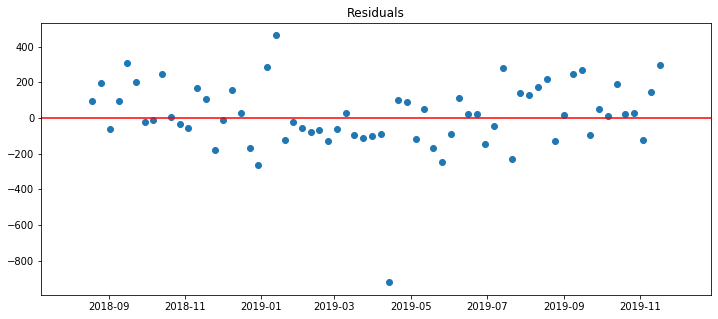

In [39]:
evaluate(y_test, resids)

In [40]:
# Calculate R2 score.
r2_score(y_test, lm_results.predict(X_test))

0.9674059573812461

In [41]:
# Calculate RMSE.
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

191.94743135201276

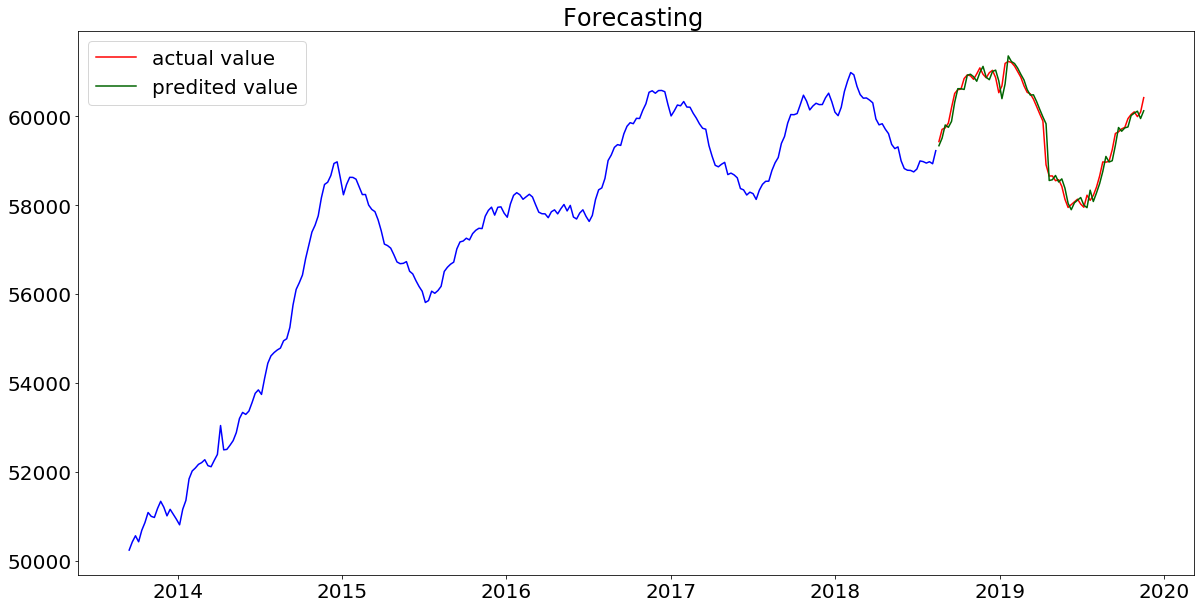

In [42]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting ', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

(736925.0, 737380.0)

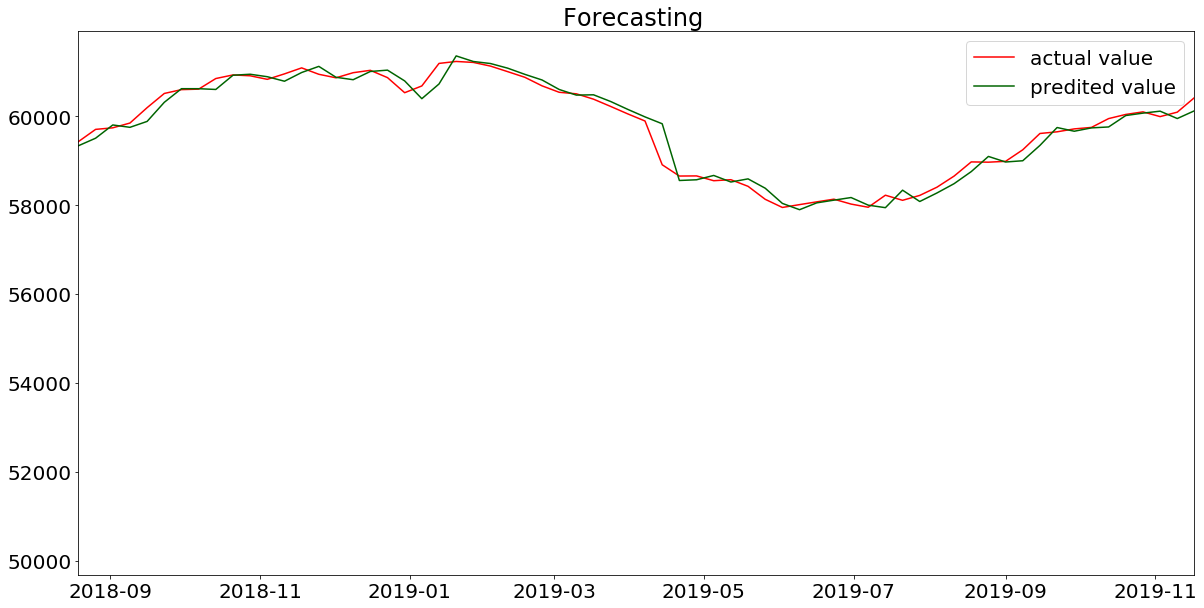

In [43]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting ', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

plt.xlim(y_test.index[0], y_test.index[-1])

**Observations**
- My forecasting is perfect? Some thing is not right here.
- bc it's based off the lag value of itself (data seems reactionary)

### OLS model 2
- Includes lag1,2 (not 3)

In [44]:
X = weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2']]\
    .drop('total_individuals_in_shelter', axis = 1)
y = weekly_df['total_individuals_in_shelter']

# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)


# Before fitting a model in statsmodels, what do we need
# to do? (Hint: Think intercept.)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# statsmodels won't be able to handle missing values.
X_train.dropna(inplace = True)

y_train = y_train[X_train.index]

/Users/dae/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

lm = sm.OLS(y_train, X_train)

# Then we fit our model.
lm_results = lm.fit()

# Display our summary!
print(lm_results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     total_individuals_in_shelter   R-squared:                       0.997
Model:                                      OLS   Adj. R-squared:                  0.997
Method:                           Least Squares   F-statistic:                 4.032e+04
Date:                          Tue, 19 Nov 2019   Prob (F-statistic):          1.19e-319
Time:                                  11:22:22   Log-Likelihood:                -1675.5
No. Observations:                           258   AIC:                             3357.
Df Residuals:                               255   BIC:                             3368.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [46]:
# Generate predicted test values.
lm_results.predict(X_test);

# Calculate R2 score.
r2_score(y_test, lm_results.predict(X_test))

0.9674048635837341

In [47]:
# Calculate RMSE.
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

191.95065203046505

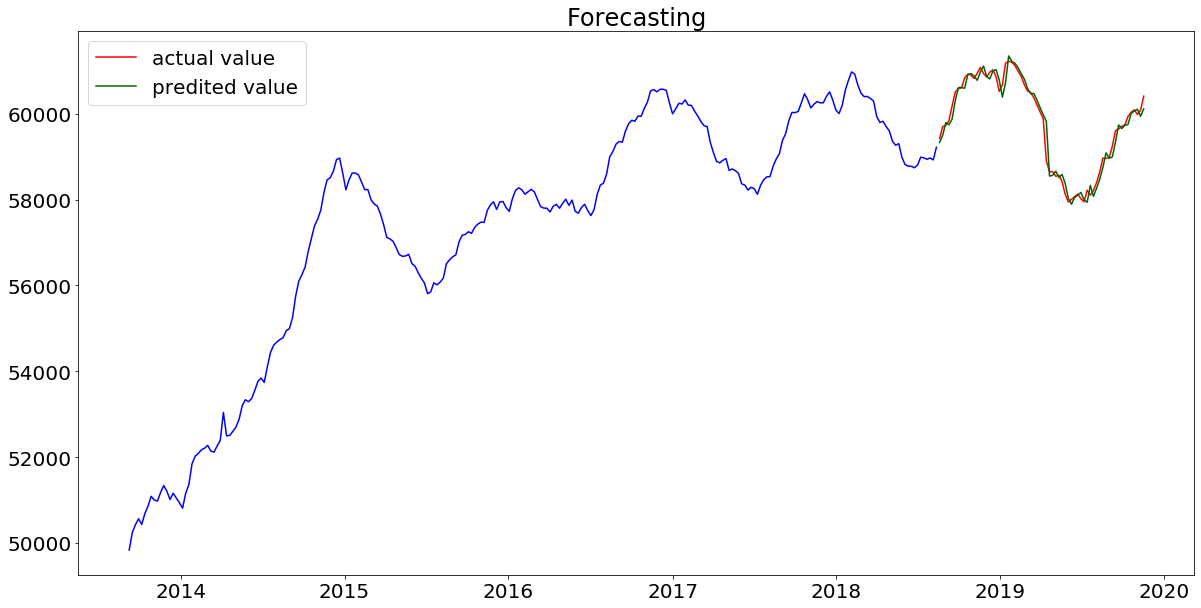

In [48]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

**Observations**
- RMSE slight increased when lag_3 was removed.

# ARIMA Model

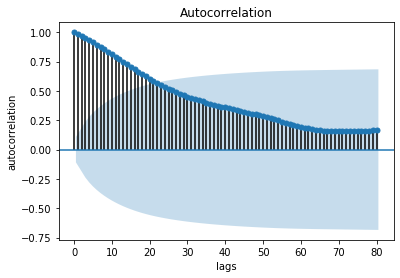

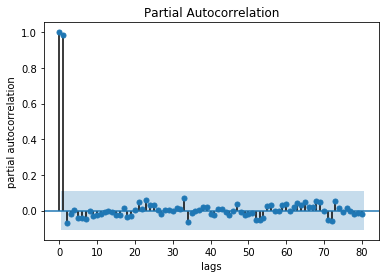

In [49]:
acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

### Decide what 'order (p, d, q)' for the model
`p` (AR: AutoRegression)
- In the PACF plot, there is a sharp cut-off in lag 3.
- lag 1 value is positive.                  
--> p-value is a lag right before the cut-off. **p=1**

`d` (I: Integration)
- By differencing the data once, p-value went below 0.05, which indicates that the data is stationary. --> **d=1**

In [50]:
adf(weekly_df['total_individuals_in_shelter'].dropna())

Test Statistic   -2.321191
p-value           0.165225
dtype: float64

In [51]:
adf(weekly_df['total_individuals_in_shelter'].diff(1).dropna())

Test Statistic   -4.621515
p-value           0.000118
dtype: float64

`q` (MA: Moving Average)
- In ACF plot, no sharp cut-off was observed.
--> **q=0**

---

> `order = (1,1,0)` was selected.

In [52]:
train, test = train_test_split(weekly_df['total_individuals_in_shelter'],
                               test_size = 0.25,
                               shuffle = False)

In [53]:
# Instantiate model
model = ARIMA(endog = train.dropna(), # endog = Y variable
              order = (1, 1, 0) ) # (p, d, q) 

# Fit model
arima_1_1_0 = model.fit()

In [54]:
# Generate prediction
preds_test = model.predict(params=arima_1_1_0.params,
                           start=test.index[0],
                           end=test.index[-1])

preds_train = model.predict(params=arima_1_1_0.params,
                            start=train.index[1], # Start at 1, instead of 0 becuase diff = 1
                            end=train.index[-1])

In [55]:
resids_test = list(test.diff(1).dropna() - preds_test[1:])
resids_train = list(train.diff(1).dropna() - preds_train)

### Analysis
1. Predicted Weekly Difference 
2. Predicted Total Individuals in Shelter
---
- As diff = 1, the predictions are weekly difference, not the number of total individuals. I calculated the predicted number of total individuals from the predicted weekly difference.

#### 1. Predicted Weekly Difference

{'mean square error': 42015.307145620114}

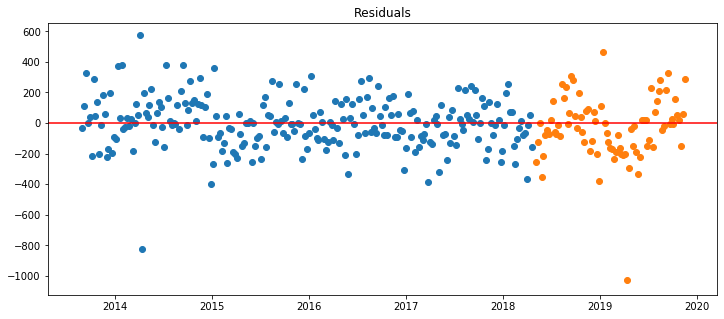

In [56]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(test.index[1:], resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

{'mean square error': 42015.307145620114}

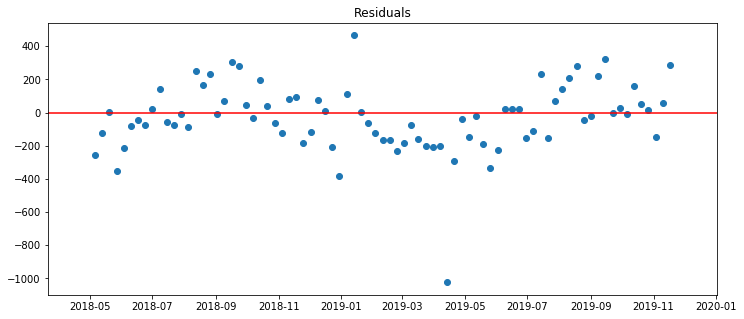

In [57]:
evaluate(test[1:], resids_test)

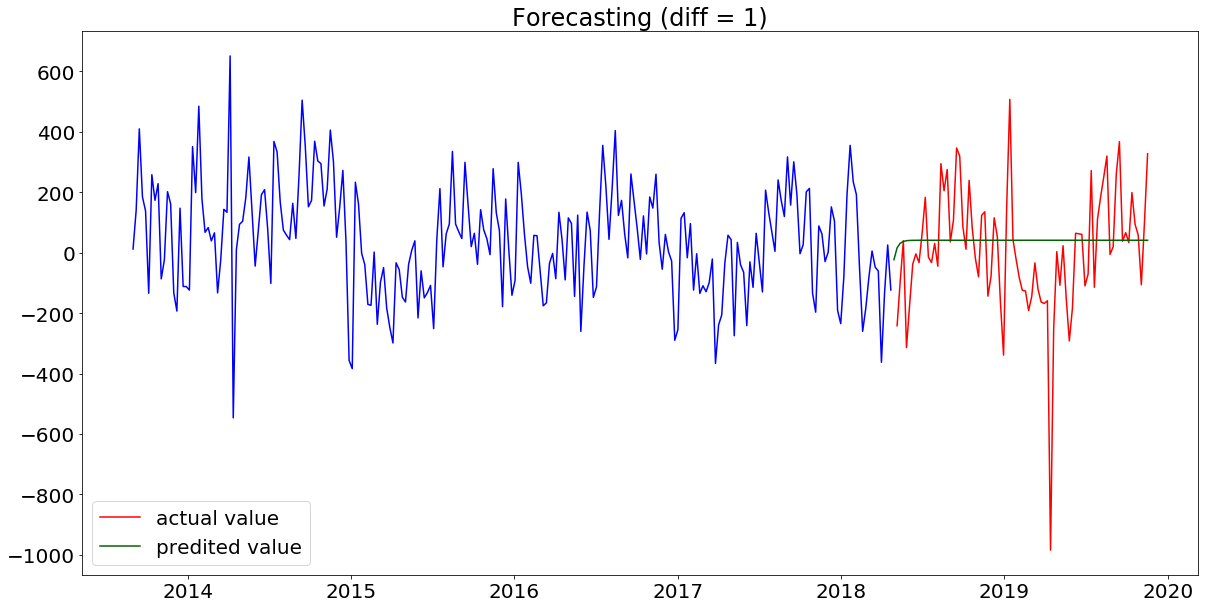

In [58]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index[1:], train.diff(1).dropna().values, color = 'blue')

# Plot testing data.
plt.plot(test.index[1:], test.diff(1).dropna().values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(test.index, preds_test, color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting (diff = 1)', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### 2. Predicted Total Individuals in Shelter

In [59]:
preds_test_index = [train.index[-1]] + list(test.index[1:])
preds_test_original_index = [train.index[-1]] + list(test.index)
preds_test_original = np.cumsum([train[-1]] + list(preds_test))
resids_test_original = list([train[-1]] + list(test) - preds_test_original)

{'mean square error': 42015.307145620114}

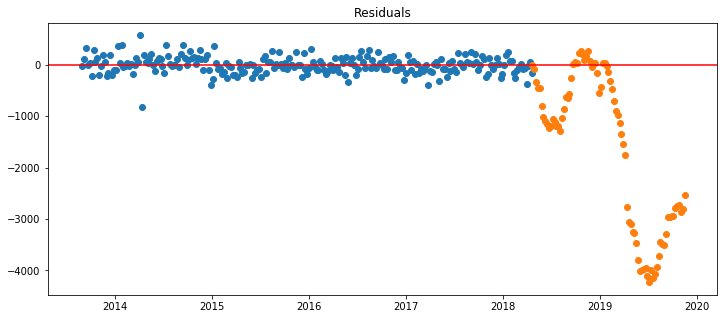

In [60]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(preds_test_original_index, resids_test_original)
plt.title('Residuals')
plt.axhline(0, color='red')
{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

{'mean square error': 4917914.9101764755}

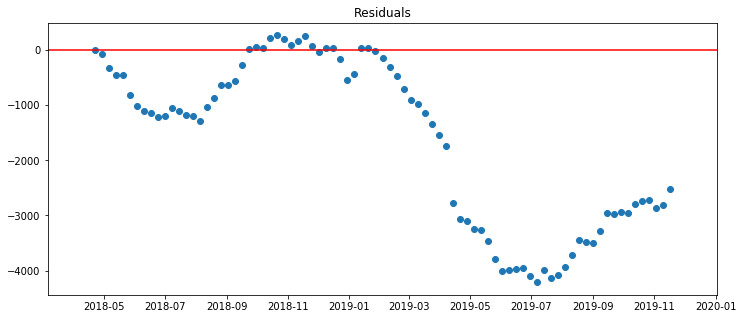

In [61]:
evaluate(weekly_df.iloc[len(train.index)-1:,:], resids_test_original)

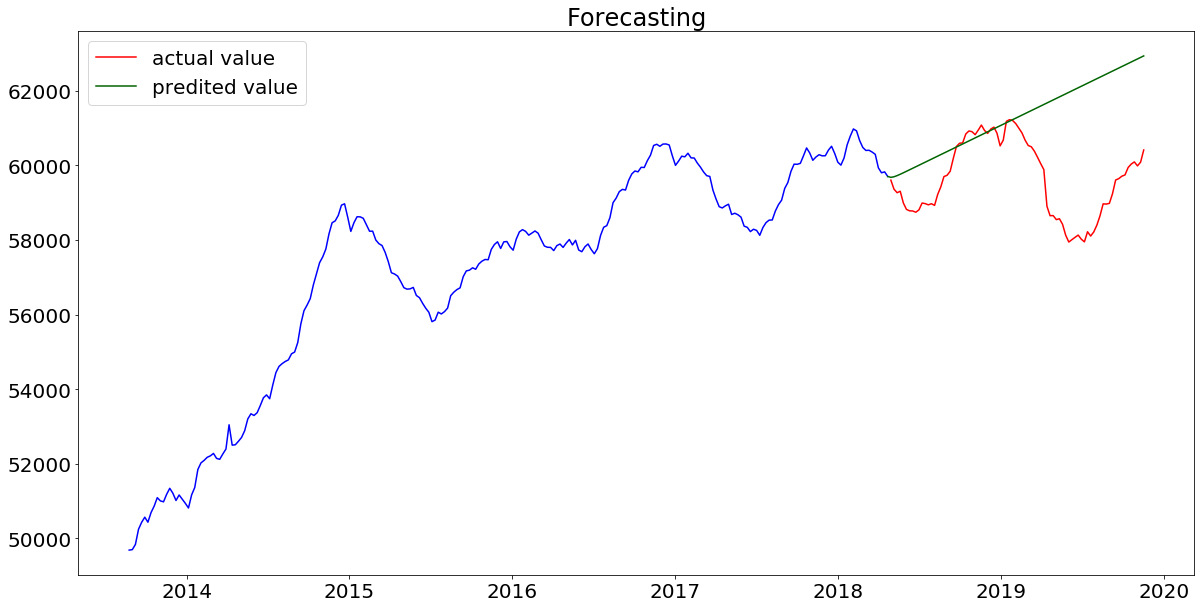

In [62]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(weekly_df.index[len(train.index)-1:], np.cumsum([train[-1]] + list(preds_test)), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# SARIMA Model

- In seasonal_decompose plot, there seems to be seasonality. This was now indicated in PACF plot.
- However, when stationarity was achieved by differencing the data once, ACF and PACF curve indicate a sign of seasonality.
- Therefore, **Try SARIMA model**

### ACF, PACF plot (diff = 1)
- Shows a sign of seasonality

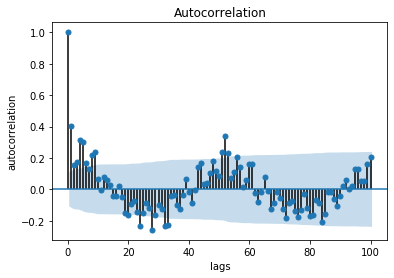

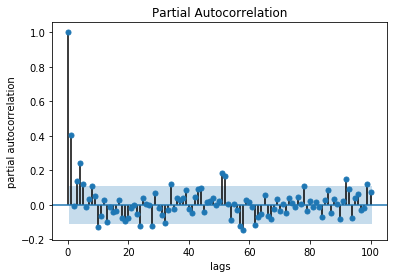

In [63]:
acf_pacf(weekly_df['total_individuals_in_shelter'].diff(1).dropna(), 100)

### Seasonal Decompose plot (diff = 0)
- Shows a sign of seasonality

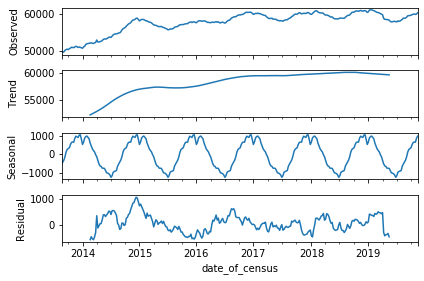

In [64]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].dropna())
decomp.plot();

### Seasonal Decompose plot (diff = 1)
- Shows a sign of seasonality

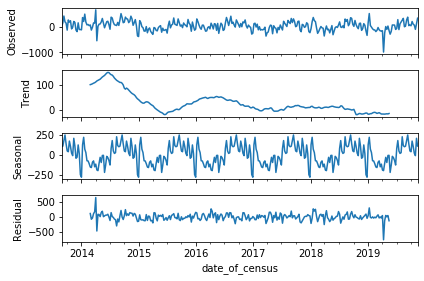

In [65]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].diff(1).dropna())
decomp.plot();

### Preliminary SARIMA
- There seems to be a seasonality every 52 weeks (1 year).
- Try `(P,D,Q,S)` = (0, 1, 0, 52)

1377637.18378532


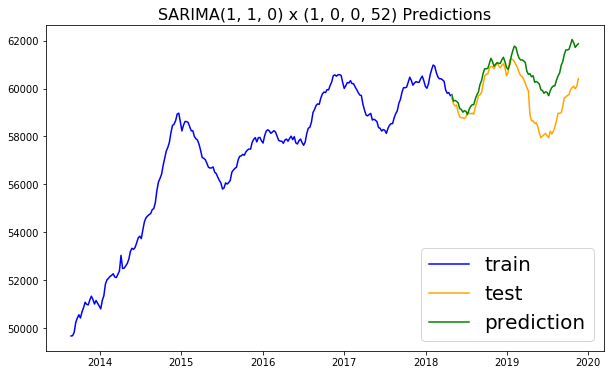

In [66]:
# Fit a SARIMA(0, 1, 0) x (0, 1, 0, 52) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (0, 1, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (1, 0, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [67]:
preds_train = model.predict(start=train.index[0], # X_test data range
                            end=train.index[-1])

In [68]:
resids_train = list(train - preds_train)

resids_test = list(test - preds)

{'mean square error': 1377637.1837853203}

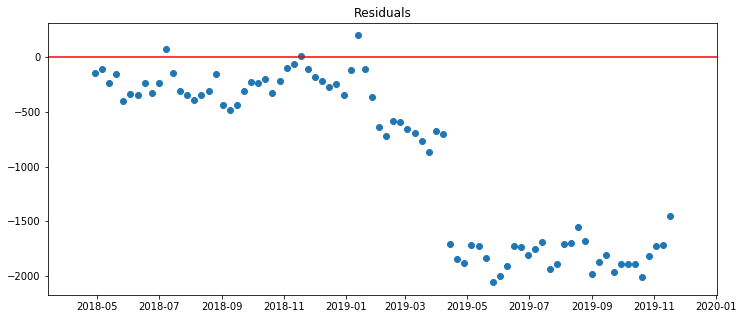

In [98]:
plt.figure(figsize = (12,5))
# plt.scatter(train.index[1:], resids_train[1:])
plt.scatter(test.index, resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

### Manual GridSearch
- Use grid search to find `seaonal_order`

In [70]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,52,int(52/3)):
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 2, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,0)
The MSE for (0, 2, 1)x(0,0,0,0) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,17)
The MSE for (0, 2, 1)x(0,0,0,17) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,34)
The MSE for (0, 2, 1)x(0,0,0,34) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 2, 1)x(0,0,0,51) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(0,1,0,17)
The MSE for (0, 2, 1)x(0,1,0,17) is: 2747470.1125006992
Attempting to fit SARIMAX(0,1,0)x(0,1,0,34)
The MSE for (0, 2, 1)x(0,1,0,34) is: 4285459.401770671
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 2, 1)x(0,1,0,51) is: 1374775.6346370508
Attempting to fit SARIMAX(0,1,0)x(0,2,0,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,0,17)
The MSE for (0, 2, 1)x(0,2,0,17) is: 198938663.39416394
Attempting to fit SARIMAX(0,1,0)x(0,2,0,34)
The MSE for (0, 2, 1)x(0,2,0,34) is: 53240322.322607055
Attempting to fit SAR

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,1,1,51) is: 2301544.972286188
Attempting to fit SARIMAX(0,1,0)x(0,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,1,17)
The MSE for (0, 2, 1)x(0,2,1,17) is: 10275854.055825831
Attempting to fit SARIMAX(0,1,0)x(0,2,1,34)
The MSE for (0, 2, 1)x(0,2,1,34) is: 6000800.314841607
Attempting to fit SARIMAX(0,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,0)
The MSE for (0, 2, 1)x(0,0,2,0) is: 1010929.607733581
Attempting to fit SARIMAX(0,1,0)x(0,0,2,17)
The MSE for (0, 2, 1)x(0,0,2,17) is: 1032020.079542479
Attempting to fit SARIMAX(0,1,0)x(0,0,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,0,2,34) is: 971317.5670630689
Attempting to fit SARIMAX(0,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,17)
The MSE for (0, 2, 1)x(0,1,2,17) is: 1327258.7498544382
Attempting to fit SARIMAX(0,1,0)x(0,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,1,2,34) is: 2269064.874238565
Attempting to fit SARIMAX(0,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,17)
The MSE for (0, 2, 1)x(0,2,2,17) is: 5914907.75311999
Attempting to fit SARIMAX(0,1,0)x(0,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,0,0)
The MSE for (0, 2, 1)x(1,0,0,0) is: 1010908.9260783677
Attempting to fit SARIMAX(0,1,0)x(1,0,0,17)
The MSE for (0, 2, 1)x(1,0,0,17) is: 1026302.6833706453
Attempting to fit SARIMAX(0,1,0)x(1,0,0,34)
The MSE for (0, 2, 1)x(1,0,0,34) is: 1015029.5861915448
Attempting to fit SARIMAX(0,1,0)x(1,0,0,51)
The MSE for (0, 2, 1)x(1,0,0,51) is: 903395.4275643232
Attempting to fit SARIMAX(0,1,0)x(1,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(1,1,0,17)
The MSE for (0, 2, 1)x(1,1,0,17) is: 1029621.50222188
Attempting to fit SARIMAX(0,1,0)x(1,1,0,34)
The MSE for (0, 2, 1)x(1,1,0,34) is: 1871429.5744699931
Attempting to fit SARIMAX(0,1,0)x(

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,1,1,51) is: 2725368.183588919
Attempting to fit SARIMAX(0,1,0)x(1,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(1,2,1,17)
The MSE for (0, 2, 1)x(1,2,1,17) is: 8325784.067445667
Attempting to fit SARIMAX(0,1,0)x(1,2,1,34)
The MSE for (0, 2, 1)x(1,2,1,34) is: 5449602.943941609
Attempting to fit SARIMAX(0,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,0)
The MSE for (0, 2, 1)x(1,0,2,0) is: 1264490.730398618
Attempting to fit SARIMAX(0,1,0)x(1,0,2,17)
The MSE for (0, 2, 1)x(1,0,2,17) is: 1009093.602035884
Attempting to fit SARIMAX(0,1,0)x(1,0,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,0,2,34) is: 918555.556245202
Attempting to fit SARIMAX(0,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,17)
The MSE for (0, 2, 1)x(1,1,2,17) is: 1237197.2060532558
Attempting to fit SARIMAX(0,1,0)x(1,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,1,2,34) is: 1973227.4058698695
Attempting to fit SARIMAX(0,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,17)
The MSE for (0, 2, 1)x(1,2,2,17) is: 1218698.5101530668
Attempting to fit SARIMAX(0,1,0)x(1,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,0,0)
The MSE for (0, 2, 1)x(2,0,0,0) is: 1011047.7563226301
Attempting to fit SARIMAX(0,1,0)x(2,0,0,17)
The MSE for (0, 2, 1)x(2,0,0,17) is: 1026763.1433752612
Attempting to fit SARIMAX(0,1,0)x(2,0,0,34)
The MSE for (0, 2, 1)x(2,0,0,34) is: 987003.8526525168
Attempting to fit SARIMAX(0,1,0)x(2,0,0,51)
The MSE for (0, 2, 1)x(2,0,0,51) is: 871996.9828067305
Attempting to fit SARIMAX(0,1,0)x(2,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,0,17)
The MSE for (0, 2, 1)x(2,1,0,17) is: 1003682.7030626526
Attempting to fit SARIMAX(0,1,0)x(2,1,0,34)
The MSE for (0, 2, 1)x(2,1,0,34) is: 2130923.8629274396
Attempting to fit SARIMAX(0,1,

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,0,1,0) is: 1257144.0038106677
Attempting to fit SARIMAX(0,1,0)x(2,0,1,17)
The MSE for (0, 2, 1)x(2,0,1,17) is: 1007314.0388744579
Attempting to fit SARIMAX(0,1,0)x(2,0,1,34)
The MSE for (0, 2, 1)x(2,0,1,34) is: 992298.775370399
Attempting to fit SARIMAX(0,1,0)x(2,0,1,51)
The MSE for (0, 2, 1)x(2,0,1,51) is: 1456331.7322426748
Attempting to fit SARIMAX(0,1,0)x(2,1,1,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,1,17)
The MSE for (0, 2, 1)x(2,1,1,17) is: 1014998.1960179909
Attempting to fit SARIMAX(0,1,0)x(2,1,1,34)
The MSE for (0, 2, 1)x(2,1,1,34) is: 1500477.0641526312
Attempting to fit SARIMAX(0,1,0)x(2,1,1,51)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,1,1,51) is: 4025068.975906232
Attempting to fit SARIMAX(0,1,0)x(2,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(2,2,1,17)
The MSE for (0, 2, 1)x(2,2,1,17) is: 2521431.7586051645
Attempting to fit SARIMAX(0,1,0)x(2,2,1,34)
The MSE for (0, 2, 1)x(2,2,1,34) is: 4472239.280759018
Attempting to fit SARIMAX(0,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,0)
The MSE for (0, 2, 1)x(2,0,2,0) is: 1279265.4655649716
Attempting to fit SARIMAX(0,1,0)x(2,0,2,17)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,0,2,17) is: 1009464.538400396
Attempting to fit SARIMAX(0,1,0)x(2,0,2,34)
The MSE for (0, 2, 1)x(2,0,2,34) is: 996963.5818965826
Attempting to fit SARIMAX(0,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,17)
The MSE for (0, 2, 1)x(2,1,2,17) is: 1053469.2396037073
Attempting to fit SARIMAX(0,1,0)x(2,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,1,2,34) is: 5499037.540088986
Attempting to fit SARIMAX(0,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,17)
The MSE for (0, 2, 1)x(2,2,2,17) is: 2527432.54420544
Attempting to fit SARIMAX(0,1,0)x(2,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,51)
Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x(2,2,0,51).
This model has an MSE of 282421.8819031788.


In [93]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,3)
The MSE for (0, 1, 0)x(0,0,0,3) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,4)
The MSE for (0, 1, 0)x(0,0,0,4) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 1, 0)x(0,0,0,51) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,0,0,52)
The MSE for (0, 1, 0)x(0,0,0,52) is: 1015011.077215033
Attempting to fit SARIMAX(0,1,0)x(0,1,0,3)
The MSE for (0, 1, 0)x(0,1,0,3) is: 13618007.814674374
Attempting to fit SARIMAX(0,1,0)x(0,1,0,4)
The MSE for (0, 1, 0)x(0,1,0,4) is: 50824198.676268935
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 1, 0)x(0,1,0,51) is: 1374775.6346370508
Attempting to fit SARIMAX(0,1,0)x(0,1,0,52)
The MSE for (0, 1, 0)x(0,1,0,52) is: 1377637.18378532
Attempting to fit SARIMAX(0,1,0)x(0,2,0,3)
The MSE for (0, 1, 0)x(0,2,0,3) is: 1419332128.346848
Attempting to fit SARIMAX(0,1,0)x(0,2,0,4)
The MSE for (0, 1, 0)x(0,2,0,4) is: 2457419657.6269555
Attempting to fit S

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,51) is: 2301544.972286188
Attempting to fit SARIMAX(0,1,0)x(0,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,52) is: 2571818.9962798557
Attempting to fit SARIMAX(0,1,0)x(0,2,1,3)
The MSE for (0, 1, 0)x(0,2,1,3) is: 92143992.59775682
Attempting to fit SARIMAX(0,1,0)x(0,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,2,1,4) is: 150466991.87738043
Attempting to fit SARIMAX(0,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,3)
The MSE for (0, 1, 0)x(0,0,2,3) is: 1011418.0320079174
Attempting to fit SARIMAX(0,1,0)x(0,0,2,4)
The MSE for (0, 1, 0)x(0,0,2,4) is: 1035094.0080838751
Attempting to fit SARIMAX(0,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,3)
The MSE for (0, 1, 0)x(0,1,2,3) is: 7549010.0599528
Attempting to fit SARIMAX(0,1,0)x(0,1,2,4)
The MSE for (0, 1, 0)x(0,1,2,4) is: 11020414.206515985
Attempting to fit SARIMAX(0,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,3)
The MSE for (0, 1, 0)x(0,2,2,3) is: 59884553.23023715
Attempting to fit SARIMAX(0,1,0)x(0,2,2,4)
The MSE for (0, 1, 0)x(0,2,2,4) is: 94926091.84350207
Attempting to fit SARIMAX(0,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,52)
Attempting

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,51) is: 2725368.183588919
Attempting to fit SARIMAX(0,1,0)x(1,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,52) is: 2125540.9301869674
Attempting to fit SARIMAX(0,1,0)x(1,2,1,3)
The MSE for (0, 1, 0)x(1,2,1,3) is: 82615838.5105558
Attempting to fit SARIMAX(0,1,0)x(1,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,1,4) is: 113888561.19208601
Attempting to fit SARIMAX(0,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,3)
The MSE for (0, 1, 0)x(1,0,2,3) is: 1138673.1724752663
Attempting to fit SARIMAX(0,1,0)x(1,0,2,4)
The MSE for (0, 1, 0)x(1,0,2,4) is: 1157857.4956316636
Attempting to fit SARIMAX(0,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,3)
The MSE for (0, 1, 0)x(1,1,2,3) is: 9447076.80927006
Attempting to fit SARIMAX(0,1,0)x(1,1,2,4)
The MSE for (0, 1, 0)x(1,1,2,4) is: 1238758.9157359884
Attempting to fit SARIMAX(0,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,2,3) is: 94609120.1235778
Attempting to fit SARIMAX(0,1,0)x(1,2,2,4)
The MSE for (0, 1, 0)x(1,2,2,4) is: 20758192.690460905
Attempting to fit SARIMAX(0,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,0,3)
The MSE for (0, 1, 0)x(2,0,0,3) is: 1020741.0326570522
Attempting to fit SARIMAX(0,1,0)x(2,0,0,4)
The MSE for (0, 1, 0)x(2,0,0,4) is: 1122707.746255627
Attempting to fit SARIMAX(0,1,0)x(2,0,0,51)
The MSE for (0, 1, 0)x(2,0,0,51) is: 871996.9828067305
Attempting to fit SARIMAX(0,1,0)x(2,0,0,52)
The MSE for (0, 1, 0)x(2,0,0,52) is: 978610.3488296558
Attempting to fit SARIMAX(0,1,0)x(2,1,0,3)
The MSE for (0, 1, 0)x(2,1,0,3) is: 22897975.11484256
Attempting to fit SARIMAX(0,1,0)x(2,1,0,4)
The MSE for (0, 1, 0)x(2,1,0,4) is: 30011439.917937465
Attempting to fit SARIMAX(0,1,0)x(2,1,0,51)
The MSE for (0, 1, 0)x(2,1,0,51) is: 1888168.1996119386
Attempting to fit SARIMAX(0,1,0)x(2,1,0,52)
The MSE for (0, 1, 0)x(2,1,0,

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,51) is: 4025068.975906232
Attempting to fit SARIMAX(0,1,0)x(2,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,52) is: 3366125.885484851
Attempting to fit SARIMAX(0,1,0)x(2,2,1,3)
The MSE for (0, 1, 0)x(2,2,1,3) is: 68710713.05899522
Attempting to fit SARIMAX(0,1,0)x(2,2,1,4)
The MSE for (0, 1, 0)x(2,2,1,4) is: 96446966.09372142
Attempting to fit SARIMAX(0,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,3)
The MSE for (0, 1, 0)x(2,0,2,3) is: 521041.6950556318
Attempting to fit SARIMAX(0,1,0)x(2,0,2,4)
The MSE for (0, 1, 0)x(2,0,2,4) is: 406110.59732513595
Attempting to fit SARIMAX(0,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,3)
The MSE for (0, 1, 0)x(2,1,2,3) is: 26070592.27589561
Attempting to fit SARIMAX(0,1,0)x(2,1,2,4)
The MSE for (0, 1, 0)x(2,1,2,4) is: 1232142.3766365494
Attempting to fit SARIMAX(0,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,3)
The MSE for (0, 1, 0)x(2,2,2,3) is: 62047084.33896135


Both gridsearch indicates that **SARIMAX(0, 2, 1)x(2,2,0,51)** minimizes MSE.

In [1]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 51) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

NameError: name 'SARIMAX' is not defined

In [105]:
resids = list(test - preds)

{'mean square error': 282421.88190317876}

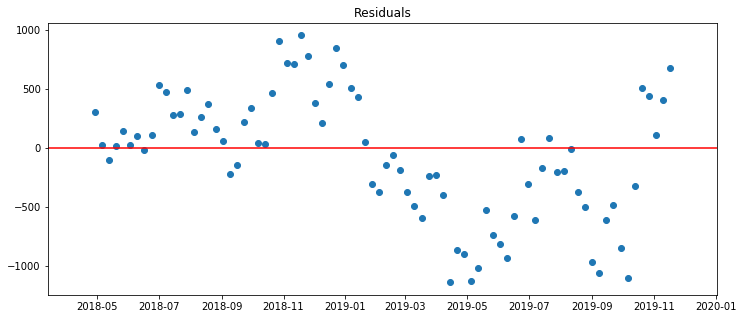

In [106]:
evaluate(test, resids)